In [1]:
#!/usr/bin/env python3

import sys, getopt
import numpy as np
from math import *
import os
import subprocess
import shlex
import regex as re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

%matplotlib widget

def intersection_element(sets, threshold = 0.95):		
    c = Counter()
    for s in sets:
        for elem in s:
            c[elem] += 1
    return [k for k, v in c.items() if v >= len(sets) * threshold]

def sort_lists(A, B, k = 3):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped]
	indices = [x[2] for x in zipped]

	return sorted_A[:k]

def sort_lists_eps(A, B, eps = 0.7):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	t_best = zipped[0][1]
	t_worst = zipped[-1][1]

	threshold = t_best + eps*(t_worst - t_best)

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped if x[1] if x[1] <= threshold]
	sorted_B = [(x[1] - t_best)/(t_worst - t_best) for x in zipped if x[1]]

	return sorted_A, sorted_B

def match_pattern(pattern, line):
	m = []
	matches = re.findall(pattern, line)
	for match in matches:
		m.append(float(match[2:]))
	return m

def average_columns(data):
    # Transpose the 2D list to get the columns as rows
    transposed_data = [[row[i] for row in data] for i in range(len(data[0]))]

    # Calculate the sum of each column and divide by the number of rows
    result = [sum(column) / len(data) for column in transposed_data]

    return result

def intersection_confidence(final_m_values, final_time_values, k_values, threshold_values, k_method = True):
	for k in k_values:
		final_set = set()
		for c in range(len(final_m_values)):
			if k_method:
				final_m = sort_lists(final_m_values[c], final_time_values[c], k)
			else:
				final_m = sort_lists_eps(final_m_values[c], final_time_values[c], k)[0]
			if c == len(final_m_values) - 1:
				print("Final m values for square:", final_m)
			final_set.add(frozenset(final_m))

		for l in threshold_values:
			values = intersection_element(final_set, l)
			if len(values) != 0:
				if k_method:
					print("Common intersection of m values with threshold " + str(l) + " and k values " + str(k), values)
				else:
					print("Common intersection of m values with threshold " + str(l) + " and eps values " + str(k), values)
					
def optimal_values(final_m_values, final_time_values, point_to_compare = 0):
	final_set = []
	for c in range(len(final_m_values)):
		final_m = sort_lists(final_m_values[c], final_time_values[c], 1)[0]
		final_set.append(final_m - point_to_compare)
	return final_set

def shared_factors(num1, num2):
    # Find the smaller of the two numbers
    if num1 < num2:
        smaller = num1
    else:
        smaller = num2

    # Initialize a variable to keep track of the number of shared factors
    shared = 0

    # Check each number from 1 to the smaller number
    for i in range(1, smaller + 1):
        # If i is a factor of both num1 and num2, increment the shared variable
        if num1 % i == 0 and num2 % i == 0:
            shared += 1

    # Return the number of shared factors
    return shared


def plot2d(x,y,thread, threshold, point_to_compare):
	plt.title("Common intersection with threshold {} and point {}".format(threshold, point_to_compare))
	plt.xlabel("Ly values")
	plt.ylabel("Difference between the optimal value and the point to compare")
	plt.plot(x, y, label = "Thread " + str(thread))
	plt.savefig("threshold_" + str(threshold) + "_point_" + str(point_to_compare) + ".png")
	plt.show()

def plot(x,y,z,thread, plot_type = "3d"):
	# Create the figure and 3D axis
	fig = plt.figure(figsize = (10,10))
	if plot_type == "3d":
		ax = fig.add_subplot(111, projection='3d')
	else:
		ax = fig.add_subplot(111)

	# Plot the data
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'][:len(x)]

	optimal_t = []
	optimal_y = []
	for i in range(len(x)):
		max_time = float(1e5)
		max_m = 0
		for j in range(len(y[i])):
			if max_time > z[i][j]:
				max_m = y[i][j]
				max_time = z[i][j]
		optimal_t.append(max_time)
		optimal_y.append(max_m)
		
	print("Max upper bound on time:", max(optimal_t),"\n")
	print("Min upper bound on time:", min(optimal_t),"\n")
	print("Average upper bound on time:", sum(optimal_t)/len(optimal_t),"\n")

	print("Max m value:", max(optimal_y),"\n")
	print("Min m value:", min(optimal_y),"\n")
	print("Average m value:", sum(optimal_y)/len(optimal_y),"\n")

	if plot_type == "3d":
	
		for i in range(len(x)):
			ax.scatter(x[i], y[i], z[i], c=colors[i%8], marker='o')
			ax.text(x[i], optimal_y[i], optimal_t[i], "OP", size=10, zorder=1, color='k')
	
		#cb = plt.colorbar(ax1, pad=0.2)

		# Set axis labels
		ax.set_title('Time taken vs Ly and m values')
		#ax.set_xticks(x)
		ax.set_ylabel('m values')
		ax.set_zlabel('time taken values')
		ax.set_xlabel('Ly values')
	else:
		plt.scatter(x, optimal_y)
		plt.title('Optimal m values vs Ly values')
		plt.ylabel('m values')
		plt.xlabel('Ly values')
		#plt.yticks(optimal_y)

	# Show the plot
	#plt.savefig("test.png")
	plt.show()

# Main Results

In [8]:
thread = [[],[],[],[],[],[],[],[]]
lx_values = [j for j in range(2, 10)]
final_m_values = []
final_time_values = []
t_array = [1]
random_averages = 2

for l in lx_values:
	print("Lx=", l, end="\n")
	for thread in t_array:
		final_m_values = []
		final_time_values = []
		final_set = set()
		ly_values = [i for i in range(2, l)]
		for i in ly_values:
			print("Thread ", thread, ": ", end=" ")
			print("Ly=", i, end="\n")
			averaged_columns_m = []
			averaged_columns_time = []
			for k in range(random_averages):
				string = "./hybridconv2 -Lx=" + str(l) + "-Ly=" + str(i) + " -Mx=" + str(2*l) +" -My=" + str(2*i) + " -t -R -T=" + str(thread)
				cmd = subprocess.run(shlex.split(string), capture_output=True, text=True)
				string = cmd.stdout

				pattern = "m="
				matches = re.finditer(pattern, string)
				for match in matches:
					# Get the starting index of the match

					start = match.start()
					if int(start) < 100:
						# Get the line number by counting the number of newline characters before the match

						line_num = string[:start].count("\n") + 1
						line_start = string.rfind("\n", 0, start) + 1
						line_end = string.find("Optimal time: ", start)
						line = string[line_start:line_end]
						# Extract the values as a float and append to a list
						m_values = match_pattern("m=\d+", line)
						time_values = match_pattern("t=\d+\.\d+", line)
				
				averaged_columns_m.append(m_values[:7])
				averaged_columns_time.append(time_values[:7])
			final_m_values.append(average_columns(averaged_columns_m)[:7])
			final_time_values.append(average_columns(averaged_columns_time)[:7])
		print("-------------------------------------------------------")
		#plot(ly_values,final_m_values,final_time_values,thread)
		final_m_values = np.array(final_m_values)
		final_time_values = np.array(final_time_values)
		np.save("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_m_values" + str(l), final_m_values)
		np.save("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_time_values" + str(l), final_time_values)

Lx= 2
-------------------------------------------------------
Lx= 3
Thread  1 :  Ly= 2
-------------------------------------------------------
Lx= 4
Thread  1 :  Ly= 2
Thread  1 :  Ly= 3
-------------------------------------------------------
Lx= 5
Thread  1 :  Ly= 2
Thread  1 :  Ly= 3
Thread  1 :  Ly= 4
-------------------------------------------------------
Lx= 6
Thread  1 :  Ly= 2


KeyboardInterrupt: 

In [ ]:
final_m_values = np.load("final_m_values.npy")
final_time_values = np.load("final_time_values.npy")

# Best m values and how often they appear
z = optimal_values(final_m_values, final_time_values, 0)
r = Counter(z)

print("Optimal values for m:", r)

# Plot Ly_values vs m_values against the optimal 2d square
ly_values = [i for i in range(2,513)]
#plot(ly_values,final_m_values,final_time_values,thread,"2d")

plot(ly_values[400:], final_m_values[400:], final_time_values, thread=1, plot_type="2d")

# Final statistics
print("Final statistics:")

# final statistics for k = 3,5,7
#intersection_confidence(final_m_values, final_time_values, [3,5,7], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], True)

# final statistcis for eps = 0.1,0.5,1
intersection_confidence(final_m_values, final_time_values, [0.1,0.2,0.5,0.6,0.9], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], False)

In [ ]:
for i in [2,4,8,16,32,64,128,256]:
	print("Ly value = ", i)
	m, time = sort_lists_eps(final_m_values[i-1], final_time_values[i-1], 0.1)
	print("m values: ", m)
	print("time values: ", time)
	print("\n")

# Square optimal Values

In [18]:
final_square_m = np.load("final_square_m_values.npy")
final_square_time = np.load("final_square_time_values.npy")
final_square_m

array([[1.600e+01, 8.000e+00, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [3.200e+01, 1.600e+01, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [1.280e+02, 6.400e+01, 3.200e+01, 2.700e+01, 2.500e+01, 1.600e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 2.000e+00],
       [2.560e+02, 1.280e+02, 6.400e+01, 4.900e+01, 3.200e+01, 2.700e+01,
        1.600e+01, 8.000e+00, 4.000e+00, 2.000e+00],
       [5.120e+02, 2.560e+02, 1.280e+02, 1.250e+02, 8.100e+01, 6.400e+01,
        3.200e+01, 1.600e+01, 8.000e+00, 4.000e+00],
       [1.024e+03, 5.120e+02, 2.560e+02, 2.430e+02, 1.280e+02, 1.250e+02,
        8.100e+01, 6.400e+01, 3.200e+01, 1.600e+01],
       [2.048e+03, 1.024e+03, 5.120e+02, 3.430e+02, 2.560e+02, 2.430e+02,
        1.280e+02, 1.250e+02, 6.400e+01, 3.200e+01]])

In [10]:
def square_optimal(square_size, threshold, epsilon):
    array3 = []
    for a in range(len(epsilon)):
        print("Epsilon = ", epsilon[a])
        print("******************************************************", end="\n")
        array2 = []
        for i in range(len(square_size)):
            print("Square size = ", square_size[i])
            final_square_m = np.load("final_square_m_values" + str(square_size[i]) + ".npy").tolist()
            final_square_time = np.load("final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            final_best_square_m = np.load("final_square_m_values.npy")
            final_best_square_time = np.load("final_square_time_values.npy")
            best_m = sort_lists(final_best_square_m[i], final_best_square_time[i], 1)[0]
            array1 = []
            for j in range(2,square_size[i]):
                if shared_factors(j, square_size[i]) > threshold:
                    m = sort_lists_eps(final_square_m[j-1], final_square_time[j-1], epsilon[a])[0]
                    if best_m in m:
                        print("Ly value = ", j)
                        array1.append(j)
            if len(array1) == 0:
                print("No Ly values found.")
                array1.append(0)
            array2.append(array1)
            print("------------------------------------------------------")
        array3.append(array2)
    return array3

epsilon = [0.05]
square_size = [16,32,64,128,256,512,1024]
threshold = 2
array3 = square_optimal(non_optimal_square_size, threshold, epsilon)

Epsilon =  0.05
******************************************************
Square size =  16
Ly value =  4
------------------------------------------------------
Square size =  32
Ly value =  4
Ly value =  8
Ly value =  12
Ly value =  28
------------------------------------------------------
Square size =  64
No Ly values found.
------------------------------------------------------
Square size =  128
Ly value =  4
Ly value =  12
Ly value =  16
Ly value =  20
Ly value =  24
Ly value =  28
Ly value =  32
Ly value =  36
Ly value =  40
Ly value =  44
Ly value =  48
Ly value =  52
Ly value =  56
Ly value =  60
Ly value =  64
Ly value =  68
Ly value =  72
Ly value =  76
Ly value =  80
Ly value =  84
Ly value =  88
Ly value =  92
Ly value =  96
Ly value =  100
Ly value =  104
Ly value =  108
Ly value =  112
Ly value =  120
Ly value =  124
------------------------------------------------------
Square size =  256
Ly value =  4
Ly value =  8
Ly value =  20
Ly value =  24
Ly value =  28
Ly value =  

In [26]:
def square_optimal(square_size, threshold, epsilon):
    array3 = []
    for a in range(len(epsilon)):
        print("Epsilon = ", epsilon[a])
        print("******************************************************", end="\n")
        array2 = []
        array_final = []
        array_x = []
        for i in range(len(square_size)):
            print("Square size = ", square_size[i])
            final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
            final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            best_m = sort_lists(final_square_m[i], final_square_time[i], 1)[0]
            array1 = []
            multiples = generate_multiples(5,5,5,5)
            for j in range(2,square_size[i]):
                if shared_factors(j, square_size[i]) > threshold:
                    m = sort_lists_eps(final_square_m[j-1], final_square_time[j-1], epsilon[a])[0]
                    if best_m in m: #and j in multiples:
                        print("Ly value = ", j)
                        array1.append(j)
                        array_final.append(array1[:1])
                        array_x.append(square_size[i])
                        break
            if len(array1) == 0:
                print("No Ly values found.")
                array1.append(0)
            array2.append(array1[:1])
            print("------------------------------------------------------")
        array3.append(array2)
    return array3, array_final, array_x

# Function to generate multiples of the form 2^a * 3^b * 5^c * 7^d
def generate_multiples(a_max, b_max, c_max, d_max):
    multiples = set()
    for a in range(a_max + 1):
        for b in range(b_max + 1):
            for c in range(c_max + 1):
                for d in range(d_max + 1):
                    multiple = 2**a * 3**b * 5**c * 7**d
                    multiples.add(multiple)
    return multiples

# Example usage
multiples = generate_multiples(10,10,10,10) # Generate multiples up to 2^3 * 3^2 * 5^1 * 7^1

epsilon = [0.005]
values = [i for i in range(3,257)]
non_optimal_square_size = values #list(filter(lambda x: x in multiples, values))
threshold = 2
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon)

Epsilon =  0.005
******************************************************
Square size =  3
No Ly values found.
------------------------------------------------------
Square size =  4
No Ly values found.
------------------------------------------------------
Square size =  5
No Ly values found.
------------------------------------------------------
Square size =  6
No Ly values found.
------------------------------------------------------
Square size =  7
No Ly values found.
------------------------------------------------------
Square size =  8
Ly value =  4
------------------------------------------------------
Square size =  9
No Ly values found.
------------------------------------------------------
Square size =  10
No Ly values found.
------------------------------------------------------
Square size =  11
No Ly values found.
------------------------------------------------------
Square size =  12
Ly value =  4
------------------------------------------------------
Square size =  13

In [27]:
c,d = 0,0
for i in range(len(array_final)):
	if array_x[i] % array_final[i][0] == 0:
		print(array_x[i], array_final[i], "divisible")
		c += 1
	else:
		print(array_x[i], array_final[i], "not divisible")
		d +=1 
print(c, d)

8 [4] divisible
12 [4] divisible
16 [4] divisible
18 [6] divisible
20 [16] not divisible
24 [4] divisible
28 [4] divisible
30 [6] divisible
32 [8] divisible
36 [6] divisible
40 [8] divisible
42 [21] divisible
44 [32] not divisible
45 [30] not divisible
48 [12] divisible
50 [20] not divisible
52 [32] not divisible
54 [6] divisible
56 [4] divisible
60 [4] divisible
63 [45] not divisible
64 [4] divisible
66 [22] divisible
68 [12] not divisible
70 [10] divisible
72 [4] divisible
75 [50] not divisible
76 [68] not divisible
78 [6] divisible
80 [8] divisible
81 [9] divisible
84 [4] divisible
88 [4] divisible
90 [6] divisible
92 [4] divisible
96 [20] not divisible
98 [14] divisible
99 [90] not divisible
100 [8] not divisible
102 [24] not divisible
104 [4] divisible
108 [6] divisible
110 [10] divisible
112 [4] divisible
114 [12] not divisible
116 [92] not divisible
117 [18] not divisible
120 [4] divisible
124 [16] not divisible
125 [25] divisible
128 [8] divisible
130 [10] divisible
132 [4] div

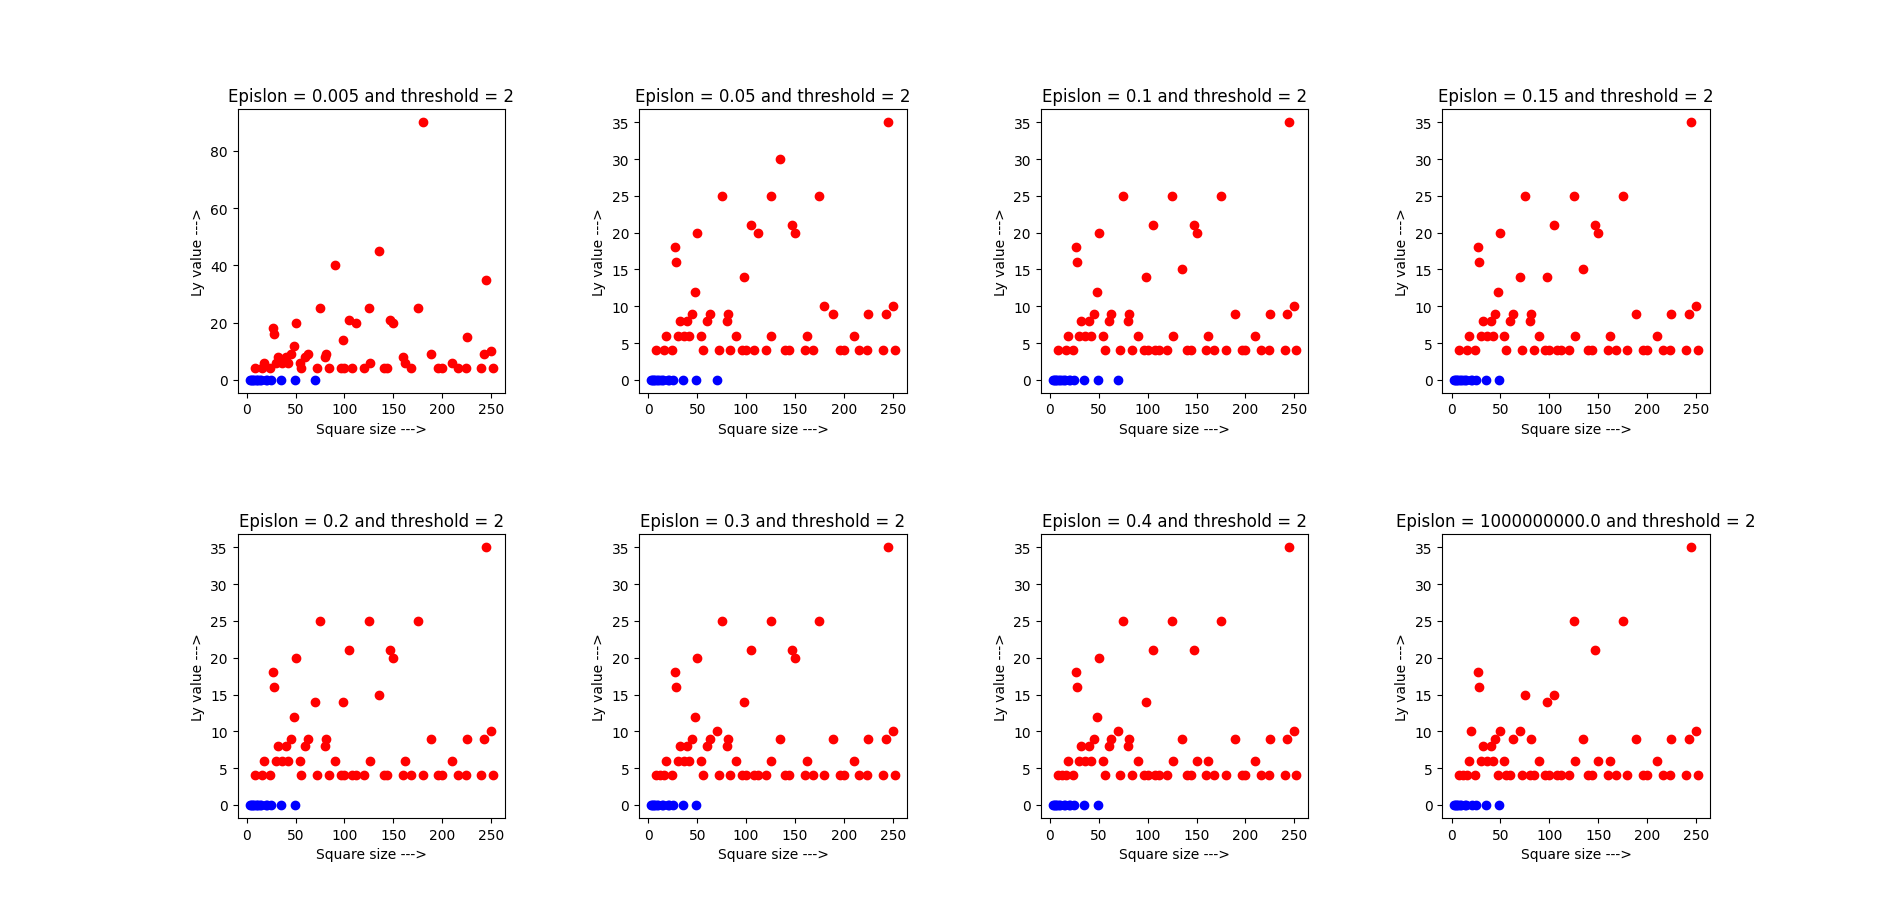

In [3]:
# old code
y = array3
x = non_optimal_square_size

fig, axs = plt.subplots(2, 4, figsize=(19, 9.2), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
r = 0
for j in range(len(epsilon)):
    if j == 4:
        r = 1
    for i in range(len(non_optimal_square_size)):
        if y[j][i] == [0]:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], color = 'blue')
        else:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], label = "Epsilon = " + str(epsilon[j]), color = 'red')

    axs[r][j%4].set_xlabel('Square size --->')
    axs[r][j%4].set_ylabel('Ly value --->')
    axs[r][j%4].set_title('Epislon = ' + str(epsilon[j]) + ' and threshold = ' + str(threshold))

plt.show()

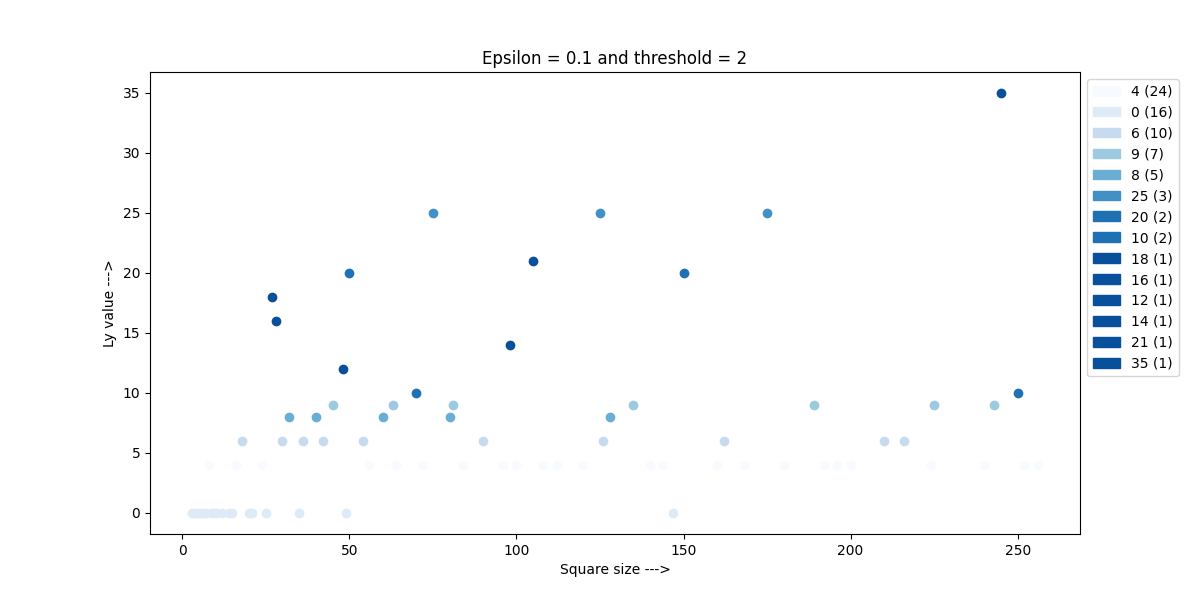

In [15]:
# plot by plot
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

y = array3
x = non_optimal_square_size
plt.figure(figsize=(12, 6))
r = 0
color_dict = {}
for j in range(len(epsilon)):
    for i in range(len(non_optimal_square_size)):
        y_value = y[j][i][0]
        if y_value in color_dict:
            color_dict[y_value].append((x[i], y_value))
        else:
            color_dict[y_value] = [(x[i], y_value)]
    count_dict = {}
    for y_value in color_dict.keys():
        count = len(color_dict[y_value])
        if count in count_dict:
            count_dict[count].append(y_value)
        else:
            count_dict[count] = [y_value]
    sorted_counts = sorted(count_dict.keys(), reverse=True)
    group_dict = {}
    color_idx = 0
    for count in sorted_counts:
        y_values = count_dict[count]
        if len(y_values) == 1:
            group_dict[y_values[0]] = cm.Blues(color_idx/len(count_dict))
            color_idx += 1
        else:
            group_color = cm.Blues(color_idx/len(count_dict))
            for y_value in y_values:
                group_dict[y_value] = group_color
            color_idx += 1
    handles = []
    for y_value in sorted(color_dict.keys(), key=lambda x: len(color_dict[x]), reverse=True):
        handles.append(mpatches.Patch(color=group_dict[y_value], label=f'{y_value} ({len(color_dict[y_value])})'))
        for point in color_dict[y_value]:
            plt.scatter([point[0]], point[1], color=group_dict[y_value])
    plt.xlabel('Square size --->')
    plt.ylabel('Ly value --->')
    plt.title('Epsilon = ' + str(epsilon[j]) + ' and threshold = ' + str(threshold))
    sm = ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=0, vmax=len(count_dict)))
    sm.set_array([])
    #plt.colorbar(sm, orientation='vertical')
    plt.legend(handles=handles, loc = 'upper left', bbox_to_anchor=(1, 1))

    plt.show()


# Machine Learning

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor


from sklearn.multioutput import MultiOutputRegressor

In [14]:
# Prepare the data
final_data = []
square_size = [i for i in range(104,904,10)]
for i in square_size:
	ly_values = [b for b in range(2,i)]
	final_m_values = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_m_values" + str(i) + ".npy").tolist()
	final_time_values = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_time_values" + str(i) + ".npy").tolist()
	for m in range(len(ly_values)):
		for n in range(len(final_m_values[m])):	
			final_data.append([ly_values[m], ly_values[m]*2, i, 2*i, final_m_values[m][n], final_time_values[m][n]])


In [15]:
final_data = np.array(final_data)
dataset = pd.DataFrame({'Ly': final_data[:, 0], 'My': final_data[:, 1], 'Lx': final_data[:, 2], 'Mx': final_data[:, 3], 'm': final_data[:, 4], 'time': final_data[:, 5]})

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376046 entries, 0 to 376045
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Ly      376046 non-null  float64
 1   My      376046 non-null  float64
 2   Lx      376046 non-null  float64
 3   Mx      376046 non-null  float64
 4   m       376046 non-null  float64
 5   time    376046 non-null  float64
dtypes: float64(6)
memory usage: 17.2 MB


In [ ]:
# ML part
X = dataset.drop(['m'], axis=1)
y = dataset[['m']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Manual Optimization

In [16]:
# ML part
X = dataset.drop(['m','time'], axis=1)
y = dataset[['m']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Prepare a dictionary of estimators after instantiating each one of them
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=100,
                                       max_features=5000,     # Out of 20000
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=100, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=100),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=100))
}

y_test_predict = dict()
y_mse = dict()

current = -1e5
model = None
for name, estimator in ESTIMATORS.items():     
    estimator.fit(X_train, y_train)                    # fit() with instantiated object
    y_mse[name] = estimator.score(X_test, y_test)
    value = y_mse[name]
    if value > current and value > 0:
        current = y_mse[name]
        best = name
        model = estimator
y_mse

{'Extra trees': 0.0631907996886274,
 'K-nn': 0.015928870999935008,
 'Linear regression': 0.26278840843345663,
 'Ridge': 0.262792652041851,
 'Lasso': 0.2627926152432535,
 'ElasticNet': 0.262792643429692,
 'RandomForestRegressor': 0.06220934140566947,
 'Decision Tree Regressor': 0.0631806083804668,
 'MultiO/P GBR': 0.2671944281324087,
 'MultiO/P AdaB': 0.2634109301417178}

In [10]:
X_test_final = X_test
y = model.predict(X_test)
X_test_final['m_predict'] = y[:] - y_test['m'].astype(int).to_numpy()
X_test_final = X_test_final.astype(int)
#X_test_final['time_predict'] = y[:,1] - y_test['time'].to_numpy()

In [12]:
X_test_final[X_test_final['m_predict'] == 0]

,Ly,My,Lx,Mx,m_predict
292,17,34,32,64,0
